In [47]:
import scipy.stats as sps
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm as tqdm_notebook

# Why we need statistics

## Toss a coin exmaple

In [91]:
# Fair coin distibution

head_probability = 0.5
fair_coin = sps.bernoulli(p=head_probability)
fair_coin_toss = fair_coin.rvs

In [92]:
# Toss a coin
fair_coin_toss()

1

In [93]:
min_tosses = 50
max_tosses = 10000
step_size = 50

tosses_array = range(min_tosses, max_tosses, step_size)
tosses_result = []

for i in tqdm_notebook(tosses_array):
    heads_part = np.mean(fair_coin_toss(i))
    tosses_result.append(heads_part)



  0%|          | 0/199 [00:00<?, ?it/s]

**Tosses vizualization**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


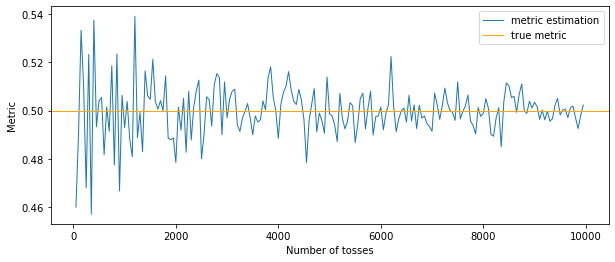

In [104]:
plt.figure(figsize=(10, 4))
plt.legend(fontsize=15)



figure = sns.lineplot(x=tosses_array,
                      y=tosses_result, 
                      palette="tab10", 
                      linewidth=1, 
                      label="metric estimation")

plt.axhline(head_probability,
            color='orange',
            linewidth=1,
            label='true metric')

plt.xlabel('Number of tosses')
plt.ylabel('Metric')

plt.legend()
plt.show()

- Each experiment gives us an estimation of real metric
- Number of tosses in sample is our information that we use for estimation
- The bigger sample we have (number of tosses) the more accurate is our estimation
- But it's always some noise that prevent us to get true metric

## Distribution of estimations

As we see our estimation accuracy strongly depends on the sample size (information we have)

Let's get an approximate distribution of possible metric values for the given sample size

### Monte-Carlo method

In [257]:
sample_size = 1000
mc_iters = int(1e4) #10k iterations

true_p = 0.5

samples = sps.binom(p=true_p, n=sample_size).rvs(mc_iters)
samples_metrics = samples / sample_size

df = pd.DataFrame(samples_metrics, columns=["samples_metrics"])

**When we ran 10k iterations, our estimations follow this distribtion:**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


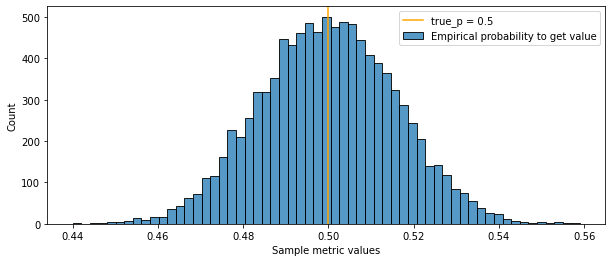

In [258]:
plt.figure(figsize=(10, 4))
plt.legend(fontsize=15)

sns.histplot(df,
             x="samples_metrics",
             palette="tab10",
             label= 'Empirical probability to get value')

plt.axvline(x=true_p, 
            c='orange',
            label=f"true_p = {round(true_p,1)}")
plt.xlabel('Sample metric values')

plt.legend()
plt.show()


So, we can see that some values occures more frequently than others. 

In [283]:
alpha = 0.1

left_bound =  np.quantile(samples_metrics, alpha/2)
right_bound = np.quantile(samples_metrics, 1-alpha/2)
df_with_ci = df.assign(ci=lambda x: (x<= left_bound) | (x >= right_bound))

**We can place a threshold that says: these value occures in only X% of all cases --> there is small possibility to get them**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


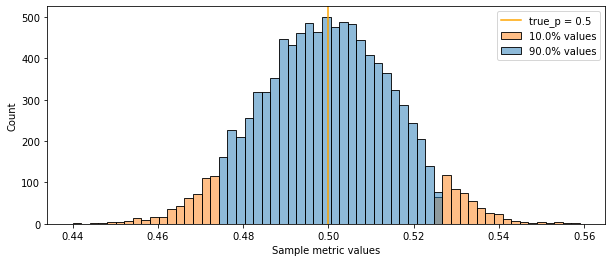

In [284]:
plt.figure(figsize=(10, 4))
plt.legend(fontsize=15)

sns.histplot(df_with_ci,
             x="samples_metrics",
             hue="ci",
             palette="tab10",
             )

plt.axvline(x=true_p, 
            c='orange')

plt.xlabel('Sample metric values')

plt.legend(labels=[f"true_p = {round(true_p,1)}", 
                   f'{(alpha) * 100}% values',
                   f'{(1-alpha) * 100}% values' 
                   ]
          )
plt.show()



In [285]:
alpha = 0.2

left_bound =  np.quantile(samples_metrics, alpha/2)
right_bound = np.quantile(samples_metrics, 1-alpha/2)
df_with_ci = df.assign(ci=lambda x: (x<= left_bound) | (x >= right_bound))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


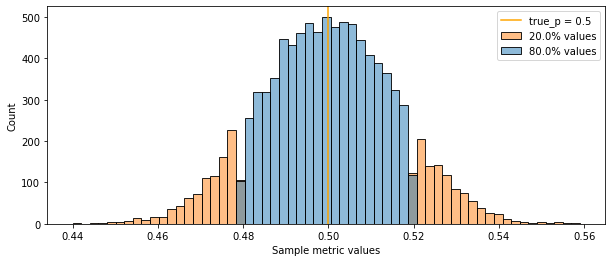

In [286]:
plt.figure(figsize=(10, 4))
plt.legend(fontsize=15)

sns.histplot(df_with_ci,
             x="samples_metrics",
             hue="ci",
             palette="tab10",
             )

plt.axvline(x=true_p, 
            c='orange')

plt.xlabel('Sample metric values')

plt.legend(labels=[f"true_p = {round(true_p,1)}", 
                   f'{(alpha) * 100}% values',
                   f'{(1-alpha) * 100}% values' 
                   ]
          )
plt.show()



At this point we can create **the rule:** 

>If our sample metric is in these *rare zones*, then it's unlikely that we have a fair coin

In statistical language we set hypotheses:

$H_0: p = 0.5$

$H_1: p <> 0.5$

Let's say, after the experiment we got 0.53 as sample metric

In [287]:
experiment_result = 0.53

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


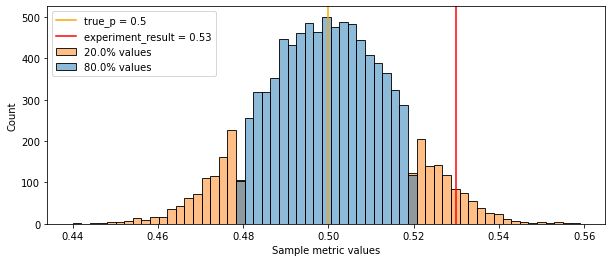

In [288]:
plt.figure(figsize=(10, 4))
plt.legend(fontsize=15)

sns.histplot(df_with_ci,
             x="samples_metrics",
             hue="ci",
             palette="tab10",
             )

plt.axvline(x=true_p, c='orange')
plt.axvline(experiment_result, color='r')

plt.xlabel('Sample metric values')


plt.legend(labels=[f"true_p = {round(true_p,1)}",
                   f"experiment_result = {round(experiment_result,2)}",
                   f'{(alpha) * 100}% values',
                   f'{(1-alpha) * 100}% values',
                   ]
          )
plt.show()

That's why we can **reject** null hypothesis

$H_0: p = 0.5$

With $\alpha$ level of significance. 

Where $\alpha$ is our threshold of how what we consider to be unlikely result


We also can calculate the probability to get such or more extreme result if $H_0$ is true

In [289]:
one_side_p_value = np.mean([x >= experiment_result for x in df_with_ci.samples_metrics]) 

In [290]:
two_sided_p_value = one_side_p_value * 2 
print(two_sided_p_value)

0.0592


In [291]:
left_bound =  np.quantile(samples_metrics, one_side_p_value)
right_bound = np.quantile(samples_metrics, 1-one_side_p_value)
df_with_p = df.assign(ci=lambda x: (x<= left_bound) | (x >= right_bound))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


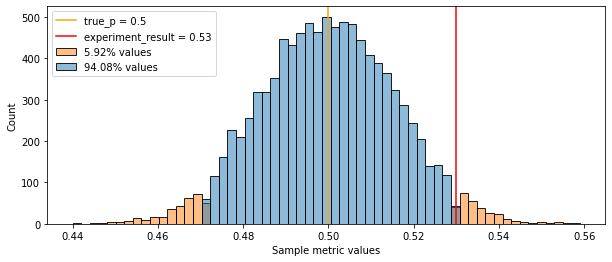

In [297]:
plt.figure(figsize=(10, 4))
plt.legend(fontsize=15)

sns.histplot(df_with_p,
             x="samples_metrics",
             hue="ci",
             palette="tab10",
             )

plt.axvline(x=true_p, c='orange')
plt.axvline(experiment_result, color='r')

plt.xlabel('Sample metric values')


plt.legend(labels=[f"true_p = {round(true_p,1)}",
                   f"experiment_result = {round(experiment_result,2)}",
                   f'{(two_sided_p_value) * 100}% values',
                   f'{(1-two_sided_p_value) * 100}% values',
                   ]
          )
plt.show()

These metric we call **p-value**

It is the probability to get this or more extreme result if null hypothesis is True

We can simply compare the **p-value** we got with our significance threshold $\alpha$ to say if we have to reject the $H_0$

In [302]:
print(f"""
p-value = {two_sided_p_value}
alpha = {alpha}

Reject H0 ? 

{"two_sided_p_value <= alpha then Reject" if two_sided_p_value <= alpha else "two_sided_p_value > alpha Not Reject"}

""")


p-value = 0.0592
alpha = 0.2

Reject H0 ? 

two_sided_p_value <= alpha then Reject




### Conclusion

Before an experiment we decide what deviations from H0 distribution we consider significant, it's our $\alpha$.

Then we calculate p-value on the result we got. If p-value is equal or less then $\alpha$ we reject H0. Because it seems unlikely to get such result if H0 is true with this level of significance